In [1]:
from cvxopt import matrix, solvers
import numpy as np
import matplotlib.pyplot as plt
import time
import math
import random
import decimal
import copy
from IPython.display import clear_output
solvers.options['show_progress'] = False

In [10]:
class Agent:
    def __init__(self, agent_id, i_state, g_state, obst, vg, wg, p_horizon, u_horizon):
        # agent state
        self.agent_id = agent_id # id of the agent
        self.agent_radius = 2
        self.obst_radius = 2
        self.i_state = np.array(i_state) # start state
        self.g_state = np.array(g_state) # goal state
        self.c_state = i_state # current state
        self.obstacles = obst
        self.n_obst = len(obst)
        # horizons
        self.p_horizon = p_horizon # planning horizon
        self.u_horizon = u_horizon # update horizon
        # initial guesses
        self.vg = matrix(vg)  # initial velocity
        self.wg = matrix(wg) # initial angular velocity
        # last known values
        self.vl = 0 # last known velocity of the agent
        self.wl = 0 # last known angular velocity of the agent
        # current values
        self.v = self.vl # current velocity
        self.w = self.wl # current angular velocity
        # dt
        self.dt = 0.1
        # lists to store vel and angular vel for debugging
        self.x_traj = []
        self.y_traj = []
        self.v_list = [self.v]
        self.w_list = [self.w]
        self.time_list = [] 
        self.avg_time = 0
        
    def get_P_q_x(self):
        
        P_x_ = np.ones((1,2*self.p_horizon))
        
        d_th = np.ones((1,self.p_horizon)) # wg1, wg1+wg2, wg1+wg2+wg3
        s = 0
        for i in range(self.p_horizon):
            s = s + self.wg[i]
            d_th[0,i] = s
        
        th_ = np.ones((1,self.p_horizon)) # th0+wg1*dt, th0+(wg1+wg2)*dt, th0+(wg1+wg2+wg3)*dt
        th_0 = self.c_state[2]   
        for i in range(self.p_horizon):
            th_[0,i] = th_0 + d_th[0,i]*self.dt
        
        d_x = np.ones((1,self.p_horizon)) # contains a, b, c
        for i in range(self.p_horizon):
            d_x[0,i] = np.cos(th_[0,i])*self.dt
        
        d_w = np.ones((1,self.p_horizon)) # contains d, e, f
        for i in range(self.p_horizon):
            d_w[0,i] = -self.vg[i]*np.sin(th_[0,i])*self.dt**2
            
        s_dw = np.ones((1,self.p_horizon)) # contains d+e+f, e+f, f
        for i in range(self.p_horizon):
            s_dw[0,i] = np.sum(d_w[0,i:self.p_horizon])
        
        P_x_[0,0:self.p_horizon] = d_x
        P_x_[0,self.p_horizon:] = s_dw
        
        P_x = P_x_.T@P_x_
        
        ### Solving for q_x
        q_x = np.ones((2*self.p_horizon))
        x_0 = self.c_state[0]
        v_sum = 0
        w_sum = 0
        for i in range(self.p_horizon):
#             v_sum = v_sum + self.vg[i]*d_x[0,i]
            w_sum = w_sum + self.wg[i]*s_dw[0,i]
            
        z = x_0 - w_sum - self.g_state[0]
        q_x[0:self.p_horizon] = 2*z*d_x
        q_x[self.p_horizon:] = 2*z*s_dw 
        return P_x, q_x
    
    def get_P_q_y(self):
        
        P_y_ = np.ones((1,2*self.p_horizon))
        
        d_th = np.ones((1,self.p_horizon)) # wg1, wg1+wg2, wg1+wg2+wg3
        s = 0
        for i in range(self.p_horizon):
            s = s + self.wg[i]
            d_th[0,i] = s
        
        th_ = np.ones((1,self.p_horizon)) # th0+wg1*dt, th0+(wg1+wg2)*dt, th0+(wg1+wg2+wg3)*dt
        th_0 = self.c_state[2]   
        for i in range(self.p_horizon):
            th_[0,i] = th_0 + d_th[0,i]*self.dt
        
        d_y = np.ones((1,self.p_horizon)) # contains a, b, c
        for i in range(self.p_horizon):
            d_y[0,i] = np.sin(th_[0,i])*self.dt
        
        d_w = np.ones((1,self.p_horizon)) # contains d, e, f
        for i in range(self.p_horizon):
             d_w[0,i] = self.vg[i]*np.cos(th_[0,i])*self.dt**2
            
        s_dw = np.ones((1,self.p_horizon)) # contains d+e+f, e+f, f
        for i in range(self.p_horizon):
            s_dw[0,i] = np.sum(d_w[0,i:self.p_horizon])
            
        
        P_y_[0,0:self.p_horizon] = d_y
        P_y_[0,self.p_horizon:] = s_dw
        
        P_y = P_y_.T@P_y_
        
        ### Solving for q_y
        q_y = np.ones((2*self.p_horizon))
        y_0 = self.c_state[1]
        w_sum = 0
        for i in range(self.p_horizon):
            w_sum = w_sum + self.wg[i]*s_dw[0,i]
            
        z = y_0 - w_sum - self.g_state[1]
        q_y[0:self.p_horizon] = 2*z*d_y
        q_y[self.p_horizon:] = 2*z*s_dw 
        
        return P_y, q_y
        
    def get_P_q_theta(self):
        P_theta = np.zeros((2*self.p_horizon,2*self.p_horizon))
        P_theta[self.p_horizon:,self.p_horizon:]=self.dt**2*np.ones((self.p_horizon,self.p_horizon))
        
        q_theta = np.zeros((2*self.p_horizon))
        theta_0 = self.c_state[2]
        theta_g = self.g_state[2]
        q_theta[self.p_horizon:]=2*(theta_0 - theta_g)*self.dt * np.ones((self.p_horizon))
    
        return P_theta, q_theta
    
    def get_diff_vel_mat(self):
        P_diff = np.zeros((self.p_horizon,self.p_horizon))
        for i in range(p_horizon-1):
            for j in range(i,i+2):
                P_diff[i,j] = 1
        P_diff[-1,-1] = 1
        P_diff = P_diff + P_diff.T - np.eye(self.p_horizon)
        P_diff = np.concatenate( (P_diff, P_diff), axis = 1 )
        P_diff = np.concatenate( (P_diff, P_diff), axis = 0 )
        
        q_diff = np.zeros((2*self.p_horizon))
        return P_diff, q_diff
    
    def get_continuity_mat(self):
        P_cont = np.zeros((self.p_horizon,self.p_horizon))
        P_cont[0,0] = 1
        P_cont = np.concatenate( (P_cont, P_cont), axis = 1 )
        P_cont = np.concatenate( (P_cont, P_cont), axis = 0 )
        
        q_cont = np.zeros((2*self.p_horizon ))
        q_cont[0] = -2*self.vl
        q_cont[self.p_horizon] = -2*self.wl
        
        return P_cont, q_cont
    
    def obst_constraint(self,obs_no, i):
        
        left_row = np.zeros((1,2*self.p_horizon))
        right_row = np.zeros((1,1))
        wg = np.array(self.wg).reshape((1,-1))
        vg = np.array(self.vg).reshape((1,-1))
        ox = self.obstacles[obs_no][0]
        oy = self.obstacles[obs_no][1]

        ## w1g, w1g+w2g, w1g+w2g+w3g
        w_sum = np.cumsum(wg[0,:i])
        theta = self.c_state[2]+w_sum*self.dt
                
        ## constant part
        s_r = (self.agent_radius + self.obst_radius)**2 + 1
        
        ## for x part
        
        kx = self.c_state[0] - ox
        cos_vec = vg[0,:i]*np.cos(theta)*self.dt
        kx = kx + np.sum(cos_vec)
        d_vx = 2*kx*np.cos(theta)*self.dt
        
        vg_theta = -vg[0,:i]*np.sin(theta)*self.dt**2
#         print(vg.shape)
        vg_sum = np.cumsum(vg_theta[::-1]) 
        vg_sum = vg_sum[::-1]
        d_wx = 2*kx*(vg_sum)
        
        const_d_vx = -vg[0,:i]*d_vx
        const_d_wx = -wg[0,:i]*d_wx
        const_x = kx**2 + np.sum(const_d_vx) + np.sum(const_d_wx)
        left_row[0,:i] = d_vx
        left_row[0,self.p_horizon:self.p_horizon+i] = d_wx
        right_row[0,0] = s_r - const_x 
        
        ## for y part
        ky = self.c_state[1] - oy
        sin_vec = vg[0,:i]*np.sin(theta)*self.dt
        ky = ky + np.sum(sin_vec)
        d_vy = 2*ky*np.sin(theta)*self.dt
        
        vg_theta = vg[0,:i]*np.cos(theta)*self.dt**2
        vg_sum = np.cumsum(vg_theta[::-1]) 
        vg_sum = vg_sum[::-1]
        d_wy = 2*ky*vg_sum
        
        const_d_vy = -vg[0,:i]*d_vy
        const_d_wy = -wg[0,:i]*d_wy
        const_y = ky**2 + np.sum(const_d_vy) + np.sum(const_d_wy)
        
        left_row[0,:i] = left_row[0,:i] + d_vy
        left_row[0,self.p_horizon:self.p_horizon+i] = left_row[0,self.p_horizon:self.p_horizon+i] + d_wy
        right_row[0,0] = right_row[0,0] - const_y
        return (-left_row, -right_row)
    
    def pred_controls(self):
        # define the cost function here and optimize the controls to minimize it

        w1 = 1

        v_cost = 99999
        w_cost = 99999
        threshold = 1
#         count = 0
        strt_time = time.time()
        while((v_cost > threshold) or (w_cost > threshold)):
            P_x, q_x = self.get_P_q_x()
            P_y, q_y = self.get_P_q_y()
            P_theta, q_theta = self.get_P_q_theta()

            
            P_cost_1 = ( P_x + P_y + P_theta ) # P matrix for goal reaching cost
            q_cost_1 = ( q_x + q_y + q_theta ) # q vector for goal reaching cost

            
            P = 2*matrix( P_cost_1 , tc='d')
            q = matrix( q_cost_1 , tc='d')
            
            ### Constraints
            
            ## Bound constraints
            
            v_bound = 5
            w_bound = 0.1
            amin = -2 # min acceleration
            amax = 1 # max acceleration
            alphamax = 0.1 # max angular acceleration
            alphamin = -0.1 # min angular acceleration
            
            v_ub = 30*np.ones((self.p_horizon,1))
            v_lb = 0*np.ones((self.p_horizon,1))
            w_ub = 0.5*np.ones((self.p_horizon,1))
            w_lb = -0.5*np.ones((self.p_horizon,1))
            a_ubound = amax * self.dt * np.ones((self.p_horizon-1,1))
            a_lbound = - amin * self.dt * np.ones((self.p_horizon-1,1))
            alpha_ubound = alphamax * self.dt * np.ones((self.p_horizon-1,1))
            alpha_lbound = - alphamin * self.dt * np.ones((self.p_horizon-1,1))

            h_mat = np.concatenate( \
                                      (v_ub, w_ub, -v_lb, -w_lb, self.vg+v_bound, self.wg+w_bound, -(self.vg-v_bound), -(self.wg-w_bound), \
                                       a_ubound, a_lbound, alpha_ubound, alpha_lbound ), \
                                      axis=0) 
            
            av_max = np.concatenate( (np.diff(np.eye(self.p_horizon),axis = 0), np.zeros( (self.p_horizon-1,self.p_horizon) ) ), axis=1 )
            av_min = -av_max
            aw_max = np.concatenate( ( np.zeros( (self.p_horizon-1,self.p_horizon) ), np.diff( np.eye(self.p_horizon) ,axis = 0 ) ), axis=1 )
            aw_min = -aw_max
            
            g_mat = np.concatenate( \
                                      ( np.eye(2*self.p_horizon),-np.eye(2*self.p_horizon), np.eye(2*self.p_horizon), -np.eye(2*self.p_horizon), \
                                      av_max, av_min, aw_max, aw_min ), \
                                      axis=0)
            for i_obs in range(self.n_obst):
                for zter in range(self.p_horizon):
                    left, right = self.obst_constraint(i_obs, zter+1)
                    g_mat = np.concatenate((g_mat, left), axis=0)
                    h_mat = np.concatenate((h_mat, right), axis=0)
                            
            h = matrix(h_mat,tc='d')
            G = matrix(g_mat,tc='d')

            ## Continuity constraints
            
            A = np.zeros((2,2*self.p_horizon))
            A[0,0] = 1
            A[1,self.p_horizon] = 1
            A = matrix(A,tc='d')
            b = matrix([self.vl, self.wl],(2,1),tc='d')
            
            sol=solvers.qp(P, q, G, h, A, b)
            v_cost = np.linalg.norm(self.vg - sol['x'][0:self.p_horizon])
            w_cost = np.linalg.norm(self.wg - sol['x'][self.p_horizon:])
            self.vg = sol['x'][0:self.p_horizon]
            self.wg = sol['x'][self.p_horizon:]   
        end_time = time.time()
        self.time_list.append(end_time-strt_time)
        return sol
       
    def non_hol_update(self):
        self.c_state[2] = self.c_state[2] + self.w*self.dt
        self.c_state[0] = self.c_state[0] + self.v*np.cos(self.c_state[2])*self.dt
        self.c_state[1] = self.c_state[1] + self.v*np.sin(self.c_state[2])*self.dt
        
    def draw_circle(self, x, y):
        th = np.arange(0,2*np.pi,0.01)
        xunit = self.agent_radius * np.cos(th) + x
        yunit = self.agent_radius * np.sin(th) + y
        return xunit, yunit  
    
    def get_traj(self,k):
        state = copy.deepcopy(self.c_state)
        for i in range(k,self.p_horizon):
            state[2] = state[2] + self.wg[i]*self.dt
            state[0] = state[0] + self.vg[i]*np.cos(state[2])*self.dt
            state[1] = state[1] + self.vg[i]*np.sin(state[2])*self.dt
            self.x_traj.append(state[0])
            self.y_traj.append(state[1])
        

In [11]:
def get_dist(a_state, o_state):
    d = np.sqrt((o_state[0] - a_state[0])**2 + (o_state[1] - a_state[1])**2)
    return d
    

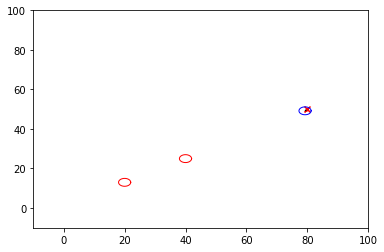

average time taken for each optimization step: 0.05217906280800148 secs


In [22]:
p_horizon = 50
u_horizon = 10

### initialize vg and wg
vg = 20*np.ones((p_horizon,1))
wg = 0.1*np.ones((p_horizon,1))
# vg = np.random.random((p_horizon,1))
# wg = np.random.random((p_horizon,1))
obs1 = np.array([40,25])
obs2 = np.array([20,13])
obstacles = [obs1, obs2]
a = Agent(1, [0,0,np.deg2rad(45)],[80,50,np.deg2rad(45)], obstacles, vg, wg, p_horizon, u_horizon)
th = 2.5
timeout = 200
rec_video = False
if(rec_video):
    plt_sv_dir = "../2_pipeline/tmp/"
    p = 0
dist1 = [] 
dist2 = []
dist1.append(get_dist(a.c_state, a.obstacles[0]))
dist2.append(get_dist(a.c_state, a.obstacles[1]))
while( (np.linalg.norm(a.c_state-a.g_state)>th) and timeout>0):
    a.pred_controls()
    for i in range(u_horizon):
        a.v = a.vg[i]
        a.w = a.wg[i]
        a.v_list.append(a.v)
        a.x_traj = []
        a.y_traj = []
        a.get_traj(i)
        a.non_hol_update()
        dist1.append(get_dist(a.c_state, a.obstacles[0]))
        dist2.append(get_dist(a.c_state, a.obstacles[1]))
        if(not rec_video):
            clear_output(wait=True)
        x,y = a.draw_circle(a.c_state[0], a.c_state[1])
        x_obs1, y_obs1 = a.draw_circle(obs1[0], obs1[1])
        x_obs2, y_obs2 = a.draw_circle(obs2[0], obs2[1])
        plt.plot(x,y,'b',linewidth=1)
        plt.plot(x_obs1, y_obs1, 'r', linewidth=1)
        plt.plot(x_obs2, y_obs2, 'r', linewidth=1)
#         plt.scatter(a.obst[0],a.obst[1],color='r')
        plt.scatter(a.g_state[0],a.g_state[1],marker='x', color='r')
        plt.scatter(a.x_traj, a.y_traj,marker='.', color='r', s=1)
        plt.plot([a.c_state[0],a.g_state[0]],[a.c_state[1],a.g_state[1]], linestyle='dotted', c='k')
        
        
        plt.xlim([-10,100])
        plt.ylim([-10,100])
#         plt.axis('square')
        if(rec_video):
            plt.savefig(plt_sv_dir+str(p)+".png",dpi=100)
            p = p+1
            plt.clf()
        else:
            plt.show()
        
        timeout = timeout - a.dt
    a.vl = a.v
    a.wl = a.w
    
a.avg_time = sum(a.time_list[1:])/27
print("average time taken for each optimization step: {} secs".format(a.avg_time))
if(timeout <= 0):
    print("Stopped because of timeout.")

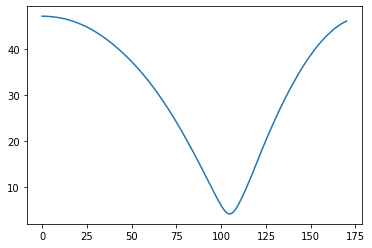

In [17]:
plt.plot(np.array(dist1))

In [18]:
min(np.array(dist1))

4.146022746361984

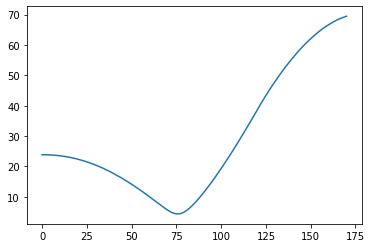

In [19]:
plt.plot(np.array(dist2))

In [20]:
min(np.array(dist2))

4.354974717501604